# Particle Filter using external data
    author: P. Ternes

In this text we track changes made in the Particle Filter code to perform data assimilation using external data. After explaining the changes made to the code, some experiments with particle filters using external data are presented.

The particle filter with these changes can be obtained [`here`](../../stationsim/particle_filter_gcs.py).

## Necessary files

This version of the particle filter uses data external to the code. For this code to work correctly, it is necessary to standardize the external data according to the instructions below.
* create a folder named <b>base_model</b>;
* create a file named <b>activation.dat</b> inside the <b>base_model</b> folder;
* create <b>N</b> files named <b>frame_i.dat</b> inside the <b>base_model</b> folder, where i varies from 1 to the N (maximum number of frames observed);

Below you will find a detailed description of how each of these files should be organized.

### activation.dat file

The activation.dat file contains information about the agents. The informations are:
* <b>agentID:</b> one unique ID that identifies the agent. Integer number;
* <b>time_activation:</b> the time that each agent is activated, that is, the time that the agent enters the environment through any gate. Real number;
* <b>gate_in:</b> the gate ID through which the agent enters the environment. Integer number;
* <b>gate_out:</b> the gate ID through which the agent leaves the environment. Integer number;
* <b>speed:</b> the average speed of the agent. Real number;
* <b>loc_desireX:</b> the $x$ position through which the agent leaves the environment. Real number;
* <b>loc_desireY:</b> the $y$ position through which the agent leaves the environment. Real number;

The first line of the file is a comment line beginning with <b>#</b> and followed by the header.
The following lines contain the information listed above, separated only by space and in the sequence mentioned. If you do not have some information, you must keep a specific column with <i>None</i>.

The file must have the structure represented below:
 
<table style="width:80%">
  <tr>
    <th>#agentID</th>
    <th>time_activation</th>
    <th>gate_in</th>
    <th>gate_out</th>
    <th>speed</th>
    <th>loc_desireX</th>
    <th>loc_desireY</th>
  </tr>
  <tr>
    <td>0</td>
    <td>24.33457</td>
    <td>6</td>
    <td>2</td>
    <td>1.7377</td>
    <td>163.2402</td>
     <td>398.95</td>  
  </tr>
  <tr>
    <td>1</td>
    <td>13.3245</td>
    <td>8</td>
    <td>4</td>
    <td>0.31979</td>
    <td>163.2402</td>
     <td>1.05</td>  
  </tr>
    <td>$\vdots$</td>
    <td>$\vdots$</td>
    <td>$\vdots$</td>
    <td>$\vdots$</td>
    <td>$\vdots$</td>
    <td>$\vdots$</td>
     <td>$\vdots$</td>  
  </tr>
</table>

### frame_i.dat

The frame_i.dat file contains information about each active agent's position in the i-th frame. The informations are:
* <b>agentID:</b> one unique ID that identifies the agent. The same ID used in the activation.dat file. Integer number;
* <b>x:</b> the agent's $x$ position in the i-th frame. Real number;
* <b>y:</b> the agent's $y$ position in the i-th frame. Real number;

The first line of the file is a comment line beginning with <b>#</b> and followed by the header.
The following lines contain the information listed above, separated only by space and in the sequence mentioned. Only active agents are listed in each frame_i.dat file. If there is no active agent in the i-th frame, save the file with the header comment only.

The file must have the structure represented below:
 
<table style="width:30%">
  <tr>
    <th>#agentID</th>
    <th>x</th>
    <th>y</th>
  </tr>
  <tr>
    <td>55</td>
    <td>198.872</td>
    <td>124.297643</td>
  </tr>
  <tr>
    <td>58</td>
    <td>168.27</td>
    <td>13.1725</td>
  </tr>
    <td>$\vdots$</td>
    <td>$\vdots$</td>
    <td>$\vdots$</td>  
  </tr>
</table>

As data assimilation is not carried out over the entire time step, it is not necessary to create files for all frames. The files really needed are the frames where data assimilation occurs and are related to the parameter <b>resample_window</b>. For example, if resample_window = 100, it is necessary the files: frame_100.dat, frame_200.dat, etc.

## Activation

To use external data is necessary pass to the particle filter a parameter with the key <b>'external_data'</b> and the value <b><i>True</i></b>. E.g. like this:

In [ ]:
model_params = {'external_data': True}

To use pseudo-truth data, pass the value <i>False</i>.


## Initial conditions

After create the base_model object inside the particle filter it is necessary to give the desired initial condition for each agent. To do that, we create the <b>set_initial_conditions()</b> method, that uses the <b>base_model/activation.dat</b> file:

In [ ]:
def set_initial_conditions(self):
    '''
     to use external file to determine some agents parameters values;
    '''
    file_name = 'base_model/activation.dat'
    agentID, time_activation, gate_in, gate_out, speed, loc_desireX, loc_desireY = np.loadtxt(file_name,unpack=True)
    i = 0
    for agent in self.base_model.agents:
        agent.unique_id = int(agentID[i])
        agent.gate_in = int(gate_in[i])
        agent.gate_out = int(gate_out[i])
        agent.loc_desire = [loc_desireX[i], loc_desireY[i]]
        agent.steps_activate = time_activation[i]
        agent.speed = speed[i]
        i += 1

## Reweight

In the <b>reweight</b> method it is necessary to obtain a measured state. To use external data, this method has been rewritten:

In [ ]:
    def reweight(self):
        '''
        Reweight

        DESCRIPTION
        Add noise to the base model state to get a measured state, or
        use external data to get a measured state. Calculate
        the distance between the particle states and the measured base model
        state and then calculate the new particle weights as 1/distance.
        Add a small term to avoid dividing by 0. Normalise the weights.
        '''
        if self.external_data:
            file_name = 'base_model/frame_' + str(self.time)+ '.dat'

            try:
                agentID, x, y = np.loadtxt(file_name,unpack=True)
                j = 0
                for agent in self.base_model.agents:
                    if (agent.unique_id in agentID):
                        
                        agent.status = 1
                        agent.location = [x[j], y[j]]
                        j += 1
                    elif (agent.status == 1):
                        agent.status = 2
            except TypeError:
                '''
                This error occurs when only one agent is active. In
                this case, the data is read as a float instead of an
                array.
                '''
                for agent in self.base_model.agents:
                    if (agent.unique_id == agentID):
                        agent.status = 1
                        agent.location = [x, y]
                    elif (agent.status == 1):
                        agent.status = 2
            except ValueError:
                '''
                 This error occurs when there is no active agent in
                 the frame.
                 - Deactivate all active agents.
                '''
                for agent in self.base_model.agents:
                    if (agent.status == 1):
                        agent.status = 2

            except OSError:
                '''
                This error occurs when there is no external file to
                read. It should only occur at the end of the simulation.
                - Deactivate all agent.
                '''
                for agent in self.base_model.agents:
                    agent.status = 2
            
            measured_state = self.base_model.get_state(sensor='location')
        else:        
            measured_state = (self.base_model.get_state(sensor='location')
                              + np.random.normal(0, self.model_std ** 2, size=self.states.shape))

        distance = np.linalg.norm(self.states - measured_state, axis=1)
        self.weights = 1 / (distance + 1e-9) ** 2
        self.weights /= np.sum(self.weights)

        return

# Experiments

Below some basic tests will be performed using external data and stationsim_gcs_model.

## Inicialization

Determine the path for the model and the filter and the necessary parameters.

In [2]:
import sys
sys.path.append('../../stationsim')
from particle_filter_gcs import ParticleFilter
from stationsim_gcs_model import Model
import multiprocessing

model_params = {
    'pop_total': 100,
    'batch_iterations': 10000,
    'do_history': False,
    'do_print': False,
    'station': 'Grand_Central',
}

filter_params = {
    'number_of_particles': 10,
    'number_of_runs': 1,
    'resample_window': 100,
    'multi_step': True,
    'particle_std': 0.5, # Particle noise read from task array variable
    'model_std': 1.0,  # was 2 or 10
    'agents_to_visualise': 100,
    'do_save': True,
    'plot_save': False,
    'do_ani': True,
    'show_ani': False, # Don't actually show the animation. They can be extracted later from self.animation
    'external_data': True
}

## Initial parameters

All particles when created are given some attributes necessary for the execution of the model. In the [`Grand Central StationSim model`](../../stationsim/stationsim_gcs_model.py), the parameters are:
unique_id
gate_in
gate_out
loc_desire
speed
steps_activate

* <b>unique_id:</b> a unique ID that relates each particle to its respective agent. Integer number;
* <b>steps_activate:</b> the time that each particle is activated, that is, the time that the agent enters the environment through any gate. Real number;
* <b>gate_in:</b> the gate ID through which the particle enters the environment. Integer number;
* <b>speed:</b> the average speed of the particle. Real number;
* <b>gate_out:</b> the gate ID through which the particle leaves the environment. Integer number;
* <b>loc_desire:</b> the $(x,~y)$ position through which the agent leaves the environment. Releated with gate_out value. One-dimensional float array with length equal 2;

This values are determine using the external data information and pass to each particle/agent. We can test the particle filter using all this initial information, or with just some of it.

#### Test 1: all initial parameters - 100 agents, 10 particles

##### Without resample

For benchmarking purposes, an experiment without using external data and without resampling will be performed:


In [5]:
filter_params = {
    'number_of_particles': 10,
    'number_of_runs': 1,
    'resample_window': 100,
    'multi_step': True,
    'particle_std': 0.5, # Particle noise read from task array variable
    'model_std': 1.0,  # was 2 or 10
    'agents_to_visualise': 100,
    'do_save': True,
    'plot_save': False,
    'do_ani': True,
    'show_ani': False, # Don't actually show the animation. They can be extracted later from self.animation
    'external_data': False,
    'do_resample' : False
}

In [6]:
pf = ParticleFilter(Model, model_params, filter_params, numcores = int(multiprocessing.cpu_count()))
result = pf.step()
pf.pool.close()

**Warning**: Not resampling. This should only be used for benchmarking
Running filter with 10 particles and 1 runs (on 8 cores) with 100 agents.
Starting particle filter step()
	Finished window 1, step 100 (took 11.49s)
	Finished window 2, step 200 (took 42.42s)
	Finished window 3, step 300 (took 40.4s)
	Finished window 4, step 400 (took 31.24s)
	Finished window 5, step 500 (took 11.99s)
	Finished window 6, step 600 (took 11.12s)
	Finished window 7, step 700 (took 4.08s)
	Finished window 8, step 800 (took 3.37s)
	Finished window 9, step 900 (took 2.75s)
	Finished window 10, step 1000 (took 1.43s)
	Finished window 11, step 1100 (took 0.77s)
	Finished window 12, step 1200 (took 0.42s)
	Finished window 13, step 1300 (took 0.26s)
	Finished window 14, step 1400 (took 0.21s)
	Finished window 15, step 1500 (took 0.15s)
	Finished window 16, step 1600 (took 0.15s)
	Finished window 17, step 1700 (took 0.1s)
	Finished window 18, step 1800 (took 0.08s)
	Finished window 19, step 1900 (took 0.06s)


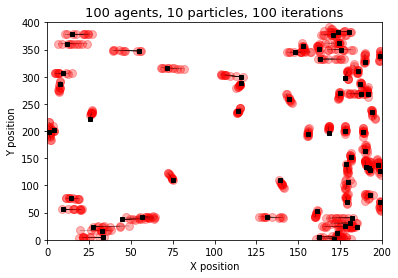

In [7]:
pf.animation[0]

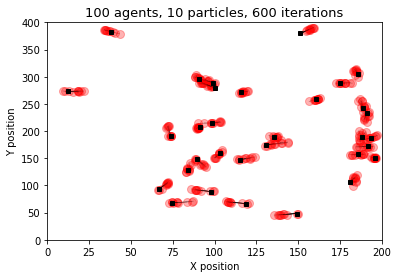

In [8]:
pf.animation[5]

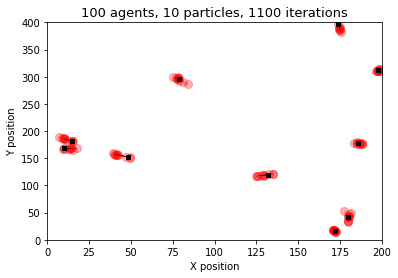

In [9]:
pf.animation[10]

In [11]:
import pprint

pp = pprint.PrettyPrinter(indent=4) # For printing nicely
for i in range(1):
    analytics = {
        'Min_Mean_errors': result[i][0],
        'Max_Mean_errors': result[i][1],
        'Average_mean_errors': result[i][2],
        'Min_Absolute_errors': result[i][3],
        'Max_Absolute_errors': result[i][4],
        'Average_Absolute_errors': result[i][5],
        'Min_variances': result[i][6],
        'Max_variances': result[i][7],
        'Average_variances': result[i][8]
        }
    if i == 0:
        print('Before resample')
    else:
        print('\nAfter resample')
    pp.pprint(analytics)


Before resample
{   'Average_Absolute_errors': 18.766968323340663,
    'Average_mean_errors': 18.766968323340663,
    'Average_variances': 7.58163363566032,
    'Max_Absolute_errors': 45.89810094649607,
    'Max_Mean_errors': 45.89810094649607,
    'Max_variances': 12.83797875674563,
    'Min_Absolute_errors': 0.6258194515021019,
    'Min_Mean_errors': 0.6258194515021019,
    'Min_variances': 0.3553573988114004}


##### With resample

Here, the above experiment is repeated with the resampling step:

In [13]:
filter_params['do_resample'] = True

pf = ParticleFilter(Model, model_params, filter_params, numcores = int(multiprocessing.cpu_count()))
result = pf.step()
pf.pool.close()

Running filter with 10 particles and 1 runs (on 8 cores) with 100 agents.
Starting particle filter step()
	Finished window 1, step 100 (took 18.28s)
	Finished window 2, step 200 (took 35.56s)
	Finished window 3, step 300 (took 24.66s)
	Finished window 4, step 400 (took 58.63s)
	Finished window 5, step 500 (took 11.03s)
	Finished window 6, step 600 (took 8.67s)
	Finished window 7, step 700 (took 5.76s)
	Finished window 8, step 800 (took 2.73s)
	Finished window 9, step 900 (took 1.23s)
	Finished window 10, step 1000 (took 0.81s)
	Finished window 11, step 1100 (took 2.42s)
	Finished window 12, step 1200 (took 0.7s)
	Finished window 13, step 1300 (took 0.36s)
	Finished window 14, step 1400 (took 0.32s)
	Finished window 15, step 1500 (took 0.27s)
	Finished window 16, step 1600 (took 0.23s)
	Finished window 17, step 1700 (took 0.16s)
	Finished window 18, step 1800 (took 0.13s)
	Finished window 19, step 1900 (took 0.08s)
	Finished window 20, step 2000 (took 0.04s)


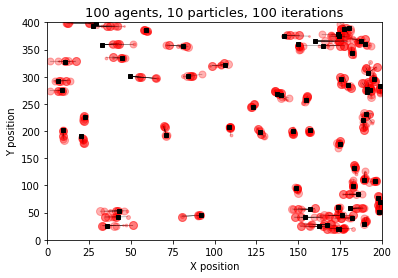

In [14]:
pf.animation[0]

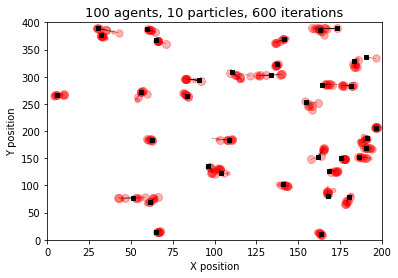

In [15]:
pf.animation[5]

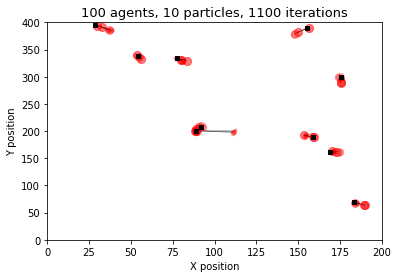

In [16]:
pf.animation[10]

In [17]:
import pprint

pp = pprint.PrettyPrinter(indent=4) # For printing nicely
for i in range(2):
    analytics = {
        'Min_Mean_errors': result[i][0],
        'Max_Mean_errors': result[i][1],
        'Average_mean_errors': result[i][2],
        'Min_Absolute_errors': result[i][3],
        'Max_Absolute_errors': result[i][4],
        'Average_Absolute_errors': result[i][5],
        'Min_variances': result[i][6],
        'Max_variances': result[i][7],
        'Average_variances': result[i][8]
        }
    if i == 0:
        print('Before resample')
    else:
        print('\nAfter resample')
    pp.pprint(analytics)


Before resample
{   'Average_Absolute_errors': 20.093567044162086,
    'Average_mean_errors': 19.86379404492443,
    'Average_variances': 6.550372942128694,
    'Max_Absolute_errors': 48.468742195333924,
    'Max_Mean_errors': 48.468742195333924,
    'Max_variances': 12.963204894913364,
    'Min_Absolute_errors': 0.09428916615852766,
    'Min_Mean_errors': 0.09869547292230715,
    'Min_variances': 1.1851616886382166}

After resample
{   'Average_Absolute_errors': 19.684275616017516,
    'Average_mean_errors': 19.425241382262982,
    'Average_variances': 7.0140021861553805,
    'Max_Absolute_errors': 46.94485174370208,
    'Max_Mean_errors': 46.47675715035993,
    'Max_variances': 11.811913543584085,
    'Min_Absolute_errors': 0.032137141163373496,
    'Min_Mean_errors': 0.03344495903826887,
    'Min_variances': 1.1277084772282118}


##### Using external data

Here, the above experiment is repeated using external data.
The external data used in these experements is in the [`base_model`](base_model/) folder. These data were obtained using the model itself and previously organized. Therefore, despite being external to the tests presented here, they are still a pseudo-real data. 

In the future, tests will be carried out with real data.

In [18]:
filter_params['external_data'] = True

pf = ParticleFilter(Model, model_params, filter_params, numcores = int(multiprocessing.cpu_count()))
result = pf.step()
pf.pool.close()

Running filter with 10 particles and 1 runs (on 8 cores) with 100 agents.
Starting particle filter step()
	Finished window 1, step 100 (took 11.31s)
	Finished window 2, step 200 (took 74.78s)
	Finished window 3, step 300 (took 41.92s)
	Finished window 4, step 400 (took 20.88s)
	Finished window 5, step 500 (took 11.52s)
	Finished window 6, step 600 (took 7.81s)
	Finished window 7, step 700 (took 4.13s)
	Finished window 8, step 800 (took 2.28s)
	Finished window 9, step 900 (took 1.36s)
	Finished window 10, step 1000 (took 1.01s)
	Finished window 11, step 1100 (took 0.59s)
	Finished window 12, step 1200 (took 0.29s)
	Finished window 13, step 1300 (took 0.17s)
	Finished window 14, step 1400 (took 0.15s)
	Finished window 15, step 1500 (took 0.57s)
	Finished window 16, step 1600 (took 0.06s)


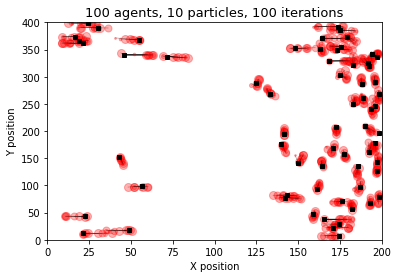

In [19]:
pf.animation[0]

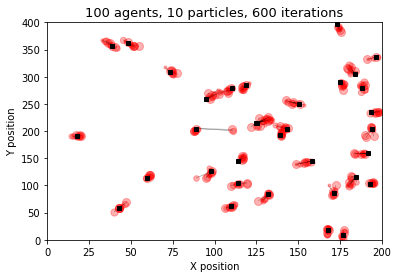

In [20]:
pf.animation[5]

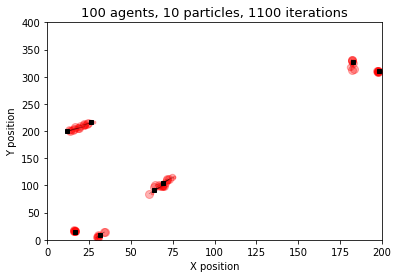

In [21]:
pf.animation[10]

In [22]:
pp = pprint.PrettyPrinter(indent=4) # For printing nicely
for i in range(2):
    analytics = {
        'Min_Mean_errors': result[i][0],
        'Max_Mean_errors': result[i][1],
        'Average_mean_errors': result[i][2],
        'Min_Absolute_errors': result[i][3],
        'Max_Absolute_errors': result[i][4],
        'Average_Absolute_errors': result[i][5],
        'Min_variances': result[i][6],
        'Max_variances': result[i][7],
        'Average_variances': result[i][8]
        }
    if i == 0:
        print('Before resample')
    else:
        print('\nAfter resample')
    pp.pprint(analytics)


Before resample
{   'Average_Absolute_errors': 227.09693928133507,
    'Average_mean_errors': 227.02092344587766,
    'Average_variances': 9.28360058982476,
    'Max_Absolute_errors': 730.9195702544886,
    'Max_Mean_errors': 731.5748627307486,
    'Max_variances': 16.619923754531094,
    'Min_Absolute_errors': 15.588602769316733,
    'Min_Mean_errors': 16.030287493807386,
    'Min_variances': 0.6133971423160738}

After resample
{   'Average_Absolute_errors': 38.105755643686116,
    'Average_mean_errors': 38.10268128285808,
    'Average_variances': 13.052534158574788,
    'Max_Absolute_errors': 282.2929502533864,
    'Max_Mean_errors': 282.2916009494429,
    'Max_variances': 18.88464169799322,
    'Min_Absolute_errors': 4.470824829918657,
    'Min_Mean_errors': 4.464650226218011,
    'Min_variances': 10.474459399536146}


#### Test 2: Without some initial parameters - 100 agents, 10 particles

In a realistic situation, the amount of data available to start a simulation will be less than that used in previous tests. Here we will present some tests performed to evaluate the results if the information passed to the Particle Filter is different.

##### Without speed

In this test the speed of each particle is determined randomly.

In [3]:
filter_params['external_data'] = True
pf = ParticleFilter(Model, model_params, filter_params, numcores = int(multiprocessing.cpu_count()))

import numpy as np
for model in pf.models:
    for agent in model.agents:
        speed_max = 0
        while speed_max <= model.speed_min:
            speed_max = np.random.normal(model.speed_mean, model.speed_std)
        agent.speeds = np.arange(speed_max, model.speed_min, - model.speed_step)
        agent.speed = np.random.choice((agent.speeds))


Running filter with 10 particles and 1 runs (on 8 cores) with 100 agents.


In [4]:
result = pf.step()
pf.pool.close()

Starting particle filter step()
	Finished window 1, step 100 (took 13.36s)
	Finished window 2, step 200 (took 41.42s)
	Finished window 3, step 300 (took 62.59s)
	Finished window 4, step 400 (took 22.09s)
	Finished window 5, step 500 (took 14.26s)
	Finished window 6, step 600 (took 18.14s)
	Finished window 7, step 700 (took 3.4s)
	Finished window 8, step 800 (took 1.53s)
	Finished window 9, step 900 (took 0.9s)
	Finished window 10, step 1000 (took 0.54s)
	Finished window 11, step 1100 (took 0.2s)
	Finished window 12, step 1200 (took 0.21s)
	Finished window 13, step 1300 (took 0.16s)
	Finished window 14, step 1400 (took 0.11s)
	Finished window 15, step 1500 (took 0.1s)
	Finished window 16, step 1600 (took 0.08s)


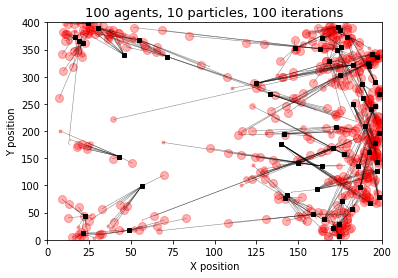

In [5]:
pf.animation[0]

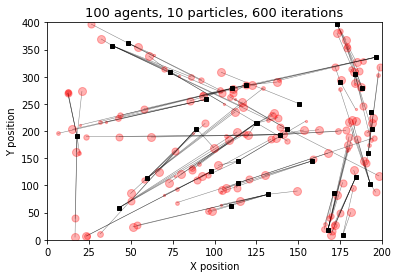

In [6]:
pf.animation[5]

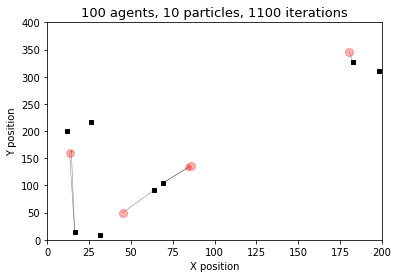

In [7]:
pf.animation[10]

In [9]:
import pprint
pp = pprint.PrettyPrinter(indent=4) # For printing nicely
for i in range(2):
    analytics = {
        'Min_Mean_errors': result[i][0],
        'Max_Mean_errors': result[i][1],
        'Average_mean_errors': result[i][2],
        'Min_Absolute_errors': result[i][3],
        'Max_Absolute_errors': result[i][4],
        'Average_Absolute_errors': result[i][5],
        'Min_variances': result[i][6],
        'Max_variances': result[i][7],
        'Average_variances': result[i][8]
        }
    if i == 0:
        print('Before resample')
    else:
        print('\nAfter resample')
    pp.pprint(analytics)


Before resample
{   'Average_Absolute_errors': 376.96278345286356,
    'Average_mean_errors': 371.03385585193683,
    'Average_variances': 1759.1412032937549,
    'Max_Absolute_errors': 805.4425165110636,
    'Max_Mean_errors': 790.6499682850119,
    'Max_variances': 3233.3577555992642,
    'Min_Absolute_errors': 20.449210620293258,
    'Min_Mean_errors': 26.430971739946617,
    'Min_variances': 909.0722274796032}

After resample
{   'Average_Absolute_errors': 305.55509022503327,
    'Average_mean_errors': 303.4911093277111,
    'Average_variances': 1842.2740048760768,
    'Max_Absolute_errors': 615.3615592339399,
    'Max_Mean_errors': 610.6054274784904,
    'Max_variances': 3046.259389980634,
    'Min_Absolute_errors': 21.052060432602488,
    'Min_Mean_errors': 21.983715428001236,
    'Min_variances': 526.0089327426048}


##### Without time_activation

In this test the time that each particle enters the environment through any gate is determined randomly.

In [10]:
filter_params['external_data'] = True
pf = ParticleFilter(Model, model_params, filter_params, numcores = int(multiprocessing.cpu_count()))

import numpy as np
for model in pf.models:
    for agent in model.agents:
        agent.steps_activate = np.random.exponential(model.gates_speed)

Running filter with 10 particles and 1 runs (on 8 cores) with 100 agents.


In [11]:
result = pf.step()
pf.pool.close()

Starting particle filter step()
	Finished window 1, step 100 (took 11.7s)
	Finished window 2, step 200 (took 58.39s)
	Finished window 3, step 300 (took 40.02s)
	Finished window 4, step 400 (took 37.93s)
	Finished window 5, step 500 (took 11.96s)
	Finished window 6, step 600 (took 11.94s)
	Finished window 7, step 700 (took 3.75s)
	Finished window 8, step 800 (took 2.24s)
	Finished window 9, step 900 (took 1.45s)
	Finished window 10, step 1000 (took 0.85s)
	Finished window 11, step 1100 (took 0.61s)
	Finished window 12, step 1200 (took 0.44s)
	Finished window 13, step 1300 (took 0.24s)
	Finished window 14, step 1400 (took 0.19s)
	Finished window 15, step 1500 (took 0.16s)
	Finished window 16, step 1600 (took 0.09s)


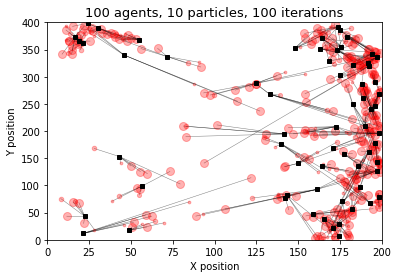

In [12]:
pf.animation[0]

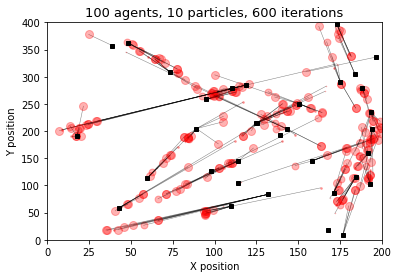

In [13]:
pf.animation[5]

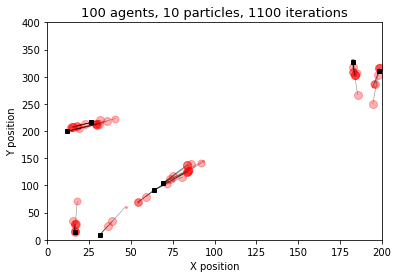

In [14]:
pf.animation[10]

In [15]:
import pprint
pp = pprint.PrettyPrinter(indent=4) # For printing nicely
for i in range(2):
    analytics = {
        'Min_Mean_errors': result[i][0],
        'Max_Mean_errors': result[i][1],
        'Average_mean_errors': result[i][2],
        'Min_Absolute_errors': result[i][3],
        'Max_Absolute_errors': result[i][4],
        'Average_Absolute_errors': result[i][5],
        'Min_variances': result[i][6],
        'Max_variances': result[i][7],
        'Average_variances': result[i][8]
        }
    if i == 0:
        print('Before resample')
    else:
        print('\nAfter resample')
    pp.pprint(analytics)


Before resample
{   'Average_Absolute_errors': 257.1120318305936,
    'Average_mean_errors': 257.29650015253816,
    'Average_variances': 696.4075189214393,
    'Max_Absolute_errors': 746.2012617354972,
    'Max_Mean_errors': 737.9993538985742,
    'Max_variances': 4343.963705364102,
    'Min_Absolute_errors': 0.5795763174210131,
    'Min_Mean_errors': 1.6381760960795622,
    'Min_variances': 83.83668361630984}

After resample
{   'Average_Absolute_errors': 248.41792806703418,
    'Average_mean_errors': 246.25128805296384,
    'Average_variances': 1366.3578012643711,
    'Max_Absolute_errors': 891.4591164155745,
    'Max_Mean_errors': 882.3224441442952,
    'Max_variances': 8705.69933263653,
    'Min_Absolute_errors': 24.01720117991519,
    'Min_Mean_errors': 24.043672551416783,
    'Min_variances': 119.30188340045423}


##### Without time_activation and without resample

In this test the time that each particle enters the environment through any gate is determined randomly.

In [18]:
filter_params['external_data'] = False
filter_params['do_resample'] = False
pf = ParticleFilter(Model, model_params, filter_params, numcores = int(multiprocessing.cpu_count()))

import numpy as np
for model in pf.models:
    for agent in model.agents:
        agent.steps_activate = np.random.exponential(model.gates_speed)

**Warning**: Not resampling. This should only be used for benchmarking
Running filter with 10 particles and 1 runs (on 8 cores) with 100 agents.


In [19]:
result = pf.step()
pf.pool.close()

Starting particle filter step()
	Finished window 1, step 100 (took 9.47s)
	Finished window 2, step 200 (took 36.03s)
	Finished window 3, step 300 (took 40.28s)
	Finished window 4, step 400 (took 23.39s)
	Finished window 5, step 500 (took 14.58s)
	Finished window 6, step 600 (took 7.37s)
	Finished window 7, step 700 (took 4.4s)
	Finished window 8, step 800 (took 2.87s)
	Finished window 9, step 900 (took 1.45s)
	Finished window 10, step 1000 (took 0.93s)
	Finished window 11, step 1100 (took 0.74s)
	Finished window 12, step 1200 (took 0.5s)
	Finished window 13, step 1300 (took 0.33s)
	Finished window 14, step 1400 (took 0.26s)
	Finished window 15, step 1500 (took 0.21s)
	Finished window 16, step 1600 (took 0.17s)
	Finished window 17, step 1700 (took 0.16s)
	Finished window 18, step 1800 (took 0.11s)
	Finished window 19, step 1900 (took 0.07s)


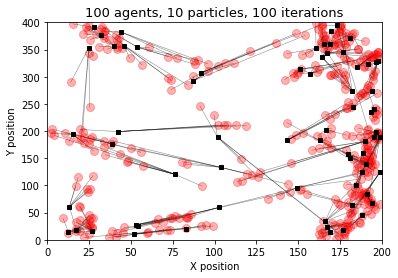

In [20]:
pf.animation[0]

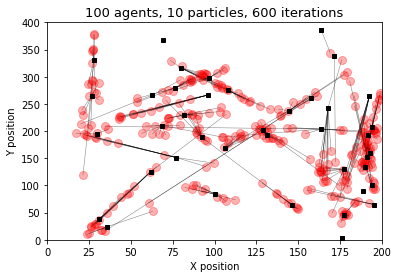

In [21]:
pf.animation[5]

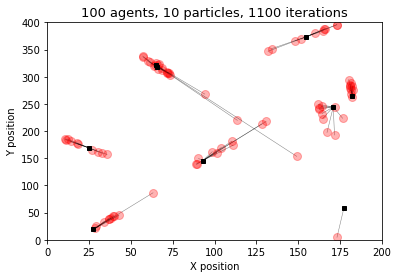

In [22]:
pf.animation[10]

In [24]:
import pprint
pp = pprint.PrettyPrinter(indent=4) # For printing nicely
for i in range(1):
    analytics = {
        'Min_Mean_errors': result[i][0],
        'Max_Mean_errors': result[i][1],
        'Average_mean_errors': result[i][2],
        'Min_Absolute_errors': result[i][3],
        'Max_Absolute_errors': result[i][4],
        'Average_Absolute_errors': result[i][5],
        'Min_variances': result[i][6],
        'Max_variances': result[i][7],
        'Average_variances': result[i][8]
        }
    if i == 0:
        print('Before resample')
    else:
        print('\nAfter resample')
    pp.pprint(analytics)


Before resample
{   'Average_Absolute_errors': 243.0651733306706,
    'Average_mean_errors': 243.0651733306706,
    'Average_variances': 1218.6999683153397,
    'Max_Absolute_errors': 1060.673016306756,
    'Max_Mean_errors': 1060.673016306756,
    'Max_variances': 8594.814197120379,
    'Min_Absolute_errors': 27.595202441323462,
    'Min_Mean_errors': 27.595202441323462,
    'Min_variances': 209.44801464736523}
